In [3]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Error processing files in /user/ml4723/Prj/NIC/ray_results/n_warehouse_46_3_real/data_driven_net_n_warehouses_real/run_2025-03-24_20-18-17/run_a63cb_00011_11_config=n_warehouse_46_3_real_lost_demand,early_stop_check_epochs=10,learning_rate=0.0001,master_n_warehouses=51_2025-03-24_20-18-17: All rows contained NaN values in loss columns
Error processing files in /user/ml4723/Prj/NIC/ray_results/n_warehouse_46_3_real/data_driven_net_n_warehouses_real/run_2025-03-24_20-18-17/run_a63cb_00001_1_config=n_warehouse_46_3_real_lost_demand,early_stop_check_epochs=10,learning_rate=0.0010,master_n_warehouses=512_2025-03-24_20-18-17: All rows contained NaN values in loss columns
Error processing files in /user/ml4723/Prj/NIC/ray_results/n_warehouse_46_3_real/data_driven_net_n_warehouses_real/run_2025-03-24_20-18-17/run_a63cb_00005_5_config=n_warehouse_46_3_real_lost_demand,early_stop_check_epochs=10,learning_rate=0.0001,master_n_warehouses=256_2025-03-24_20-18-17: All rows contained NaN values in lo

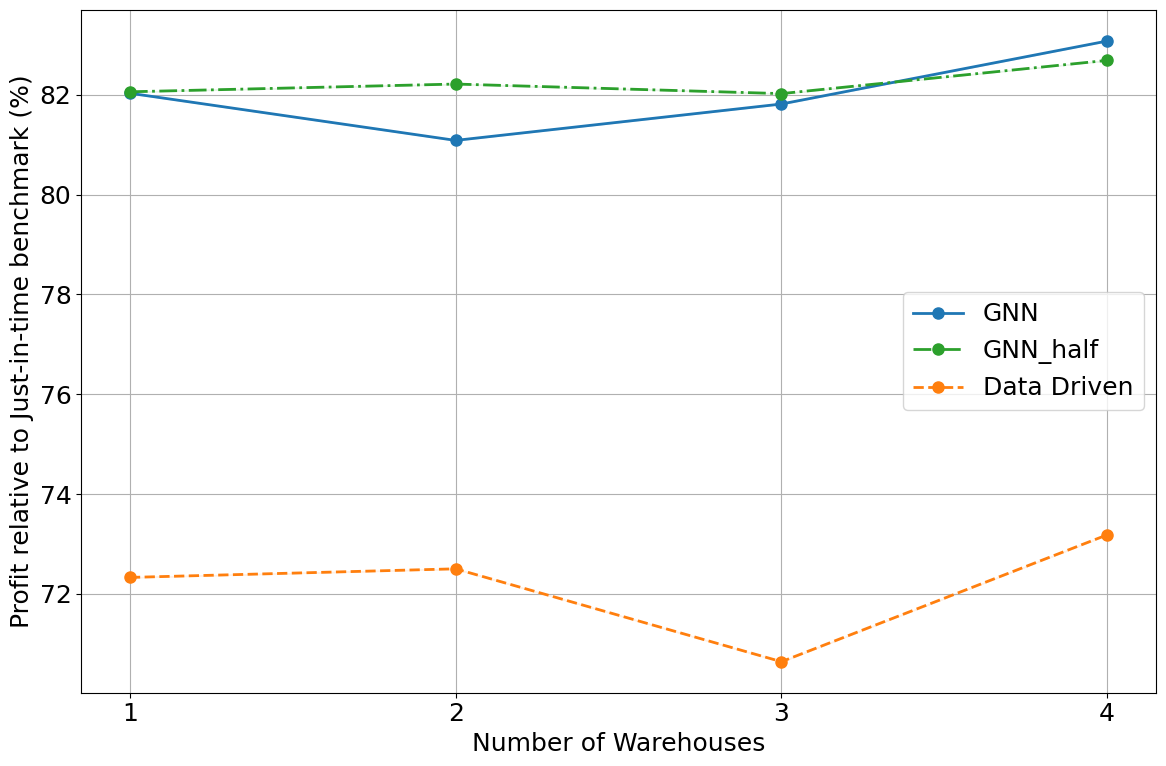

In [6]:
# Create vanilla results dataframe from the provided data
testset_names = ["n_warehouse_46_1_real", "n_warehouse_46_2_real", "n_warehouse_46_3_real", "n_warehouse_46_4_real"]

results_interpretor = rri.RayResultsinterpreter()

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

# Define color scheme and line styles
color_scheme = {
    "GNN": "#1f77b4",    # Blue
    "GNN_half": "#2ca02c",  # Green
    "Data Driven": "#ff7f0e"   # Orange
}

linestyle_scheme = {
    "GNN": "-",               # Solid
    "GNN_half": "-.",         # Dash-dot
    "Data Driven": "--"       # Dashed
}

# Define paths for each architecture
architectures = {
    "GNN": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/GNN_real',
    "GNN_half": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/GNN_half_real',
    "Data Driven": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/data_driven_net_n_warehouses_real',
    "Just-in-time": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/just_in_time_real'
}

sort_by = 'train_loss'
pick_row_from_run_by = 'train_loss'

dfs = []

# Create dataframes for each architecture and testset
for arch_name, path_fn in architectures.items():
    for testset_name in testset_names:
        path = path_fn(testset_name)
        n_warehouses = int(testset_name.split('_')[3])  # Extract warehouse number from testset name
        
        df = results_interpretor.make_table({1: path},
            {'samples': [1]},
            default_condition_setter, custom_data_filler,
            sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by,
            test_loss_limit = 100)
        if df.empty:
            continue
        
        df.insert(2, 'Architecture Class', arch_name)
        df.insert(1, 'hyperparam_name', arch_name)
        df['n_warehouses'] = n_warehouses
        dfs.append(df)

# Combine all dataframes
df = pd.concat(dfs, ignore_index=True)

# Calculate relative profit percentage using just-in-time as baseline
stats_by_arch_and_warehouses = {}
for n_warehouses in range(1, 5):  # 1 to 4 warehouses
    warehouse_data = df[df['n_warehouses'] == n_warehouses].copy()
    if warehouse_data.empty:
        continue
        
    jit_loss = warehouse_data[warehouse_data['Architecture Class'] == 'Just-in-time']['Dev Loss'].values[0]
    warehouse_data.loc[:, 'Profit %'] = (warehouse_data['Dev Loss'] / jit_loss) * 100
    
    for arch in ['GNN', 'GNN_half', 'Data Driven']:  # Plot these three
        key = arch
        if key not in stats_by_arch_and_warehouses:
            stats_by_arch_and_warehouses[key] = []
            
        arch_data = warehouse_data[warehouse_data['Architecture Class'] == arch]
        if not arch_data.empty:
            profits = arch_data['Profit %'].to_numpy()
            mean_profit = np.mean(profits)
            std_profit = np.std(profits)
            ci_95 = 1.96 * std_profit / np.sqrt(len(profits))
            stats_by_arch_and_warehouses[key].append({
                'n_warehouses': n_warehouses,
                'mean_profit': mean_profit,
                'ci_lower': mean_profit - ci_95,
                'ci_upper': mean_profit + ci_95
            })

# Create plot
FONTSIZE = 18
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': FONTSIZE})

# Plot lines
for arch, stats in stats_by_arch_and_warehouses.items():
    stats_df = pd.DataFrame(stats)
    if not stats_df.empty:
        warehouses_array = stats_df['n_warehouses'].to_numpy()
        mean_profit_array = stats_df['mean_profit'].to_numpy()
        ci_lower_array = stats_df['ci_lower'].to_numpy()
        ci_upper_array = stats_df['ci_upper'].to_numpy()
        
        plt.plot(warehouses_array, mean_profit_array,
                color=color_scheme[arch],
                linestyle=linestyle_scheme[arch],
                linewidth=2,
                marker='o',
                markersize=8,
                label=arch)
        
        plt.fill_between(warehouses_array,
                        ci_lower_array,
                        ci_upper_array,
                        color=color_scheme[arch],
                        alpha=0.1)

plt.xlabel('Number of Warehouses', fontsize=FONTSIZE)
plt.ylabel('Profit relative to Just-in-time benchmark (%)', fontsize=FONTSIZE)
plt.grid(True)
plt.legend(fontsize=FONTSIZE)

plt.xticks(range(1, 5), fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.tight_layout()
plt.show()

In [12]:
df

,# of stores,hyperparam_name,samples,Architecture Class,Learning Rate,Train Loss,Dev Loss,# of runs,path,n_warehouses
0,1,GNN,1,GNN,0.001,-694.237492,-607.364603,9,/user/ml4723/Prj/NIC/ray_results/n_warehouse_4...,1
1,1,GNN,1,GNN,0.001,-703.504560,-600.369413,9,/user/ml4723/Prj/NIC/ray_results/n_warehouse_4...,2
2,1,GNN,1,GNN,0.001,-701.874751,-605.765410,8,/user/ml4723/Prj/NIC/ray_results/n_warehouse_4...,3
3,1,GNN,1,GNN,0.001,-705.068541,-615.108473,9,/user/ml4723/Prj/NIC/ray_results/n_warehouse_4...,4
4,1,GNN_half,1,GNN_half,0.010,-684.806712,-599.120955,9,/user/ml4723/Prj/NIC/ray_results/n_warehouse_4...,1
5,1,GNN_half,1,GNN_half,0.001,-691.232083,-610.757831,9,/user/ml4723/Prj/NIC/ray_results/n_warehouse_4...,2
6,1,GNN_half,1,GNN_half,0.001,-682.934955,-600.282268,9,/user/ml4723/Prj/NIC/ray_results/n_warehouse_4...,3
7,1,GNN_half,1,GNN_half,0.001,-688.046396,-604.873319,9,/user/ml4723/Prj/NIC/ray_results/n_warehouse_4...,4
8,1,Data Driven,1,Data Driven,0.001,-737.460360,-535.543208,27,/user/ml4723/Prj/NIC/ray_results/n_warehouse_4...,1
9,1,Data Driven,1,Data Driven,0.001,-739.770978,-536.820198,27,/user/ml4723/Prj/NIC/ray_results/n_warehouse_4...,2
